In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from Wrapper.W_momen_factor_create import *
from Wrapper.W_pre_factor_data_mani import *
from Wrapper.W_pre_opt_data_mani import wrapper_df_preparation
from Wrapper.W_pre_opt_obj_func import (wrapper_objective_compo_creation,
                                               wrapper_objective_func)
import scipy.optimize as opt
from Wrapper.Moduel.M_FactorCreator import FactorsConstruction
from Wrapper.W_pre_opt_factor_standardize import wrapper_standardize_factor
from Wrapper.Moduel.M_SupportFunction import (weight_prediction,get_new_factor_value)
from Wrapper.W_opt_ppp import PPP_optimize
from Wrapper.Moduel.M_BackTest import BackTest
from Wrapper.Moduel.M_BenchmarkBacktest import BenchmarkStrategy, BenchmarkIndex
from Wrapper.Moduel.M_PerforEvalu import ModelFreeEvaluation
from Wrapper.Moduel.M_DataMani import BasicManipulation

def plot_multiple_series(dataframe,date_name, colname_list):
    plt.figure(figsize = (20,10))
    for colname in colname_list:
        plt.plot(dataframe[date_name],dataframe[colname])

## Data Preparation 

In [2]:
price_file = "Data/Chinese_stock.csv"
price_df, ticker_list = wrapper_import_data(price_file)
return_df, factor_df = wrapper_return_calculation(price_df, 
                           ticker_list,
                           look_back_list=[1],skip=0,
                           target_name='price',frequency='BM')
factor_df, return_df  = wrapper_factor_return_output(return_df,factor_df)
factor_list = ["momentum_1"]
reshape_dic = wrapper_df_preparation(return_df,factor_df,factor_list)
factor_dic = reshape_dic["factor_dic"]

C:\Users\clair\Repos\PPP_Optimization\Wrapper\Moduel\M_PanelFormatter.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  x[shift_target] = x[shift_target].shift(shift_step)


In [3]:
ret_mat = reshape_dic["ret_mat"]
factor_dic.update({'ret_mat':ret_mat})
ret_mat_test = pd.DataFrame(ret_mat)
ret_mat_test = ret_mat_test.shift(1)
ret_mat_test = np.array(ret_mat_test)
date_df = return_df[return_df['ticker']==ticker_list[0]]
date = date_df['date']

In [4]:
general_dic = {'ticker_list':ticker_list,'ret_mat_test':ret_mat_test,'factor_list':factor_list,'date':date}
factor_dic = wrapper_standardize_factor(ticker_list,factor_dic)
data_dict ={'strategy_specific_data':factor_dic,'general_data':general_dic}

## Strategy Back Test

### Back Test Detail

In [5]:
def func(x):
    final_weight = PPP_optimize(x,ticker_list=ticker_list,factor_list=factor_list)
    return final_weight

strategy_est_length = 20
end_index = 160
update = 1

### Back Test Implementation

In [6]:
back_obj = BackTest(data_dict,func)
rp_storage, weight_storage,date_storage = back_obj.historical_backtest(est_length = strategy_est_length,
                                                                       start_index=101,
                                                                       end_index=end_index,
                                                                       update=1,
                                                                       fixed=True)

Optimization terminated successfully.
         Current function value: 0.246505
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 0.240991
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 0.239934
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 0.243274
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 0.240888
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 0.238869
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 0.233236
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

### Back Test Result Evaluation

In [7]:
obj = BenchmarkStrategy(rp_storage,date_storage)

In [8]:
final_return_df = obj.equalweight(data= data_dict ,asset_num = 9, update=1,fixed=True)

In [9]:
obj_1 = ModelFreeEvaluation(final_return_df['strategy_return'],final_return_df['date'])
obj_2 = ModelFreeEvaluation(final_return_df['benchmark_return'],final_return_df['date'])

In [10]:
sharpe_1 = obj_1.sharpe_ratio(annul_freq=12,rf=0.0016)
sharpe_2 = obj_2.sharpe_ratio(annul_freq=12,rf=0.0016)

In [11]:
cum_ret_1 = obj_1.cum_ret_calculation()
cum_ret_2 = obj_2.cum_ret_calculation()

In [12]:
dd1, mdd1, ddd1 = obj_1.drawdown_calculation()
dd2, mdd2, ddd2 = obj_2.drawdown_calculation()

In [13]:
final_return_df['cum_ret_1']=cum_ret_1
final_return_df['cum_ret_2']=cum_ret_2
final_return_df['dd1'] = dd1
final_return_df['dd2'] = dd2

In [14]:
sharpe_1

0.7771217646197858

In [15]:
sharpe_2

0.7389665494984394

In [16]:
mdd1

-0.4060393693441888

In [17]:
mdd2

-0.42308719938269057

In [18]:
ddd1

40.0

In [19]:
ddd2

40.0

In [20]:
ret_series = final_return_df.strategy_return
date_series = final_return_df.date

In [21]:
obj = BenchmarkIndex(ret_series,date_series)

In [22]:
index_comparison = obj.sp500_index_comparison(ret=True)

In [23]:
obj_3 = ModelFreeEvaluation(index_comparison['sp500'],index_comparison['date'])

In [24]:
sharpe_3 = obj_3.sharpe_ratio(annul_freq=12,rf=0.0016)

In [25]:
cum_ret_3 = obj_3.cum_ret_calculation()

In [26]:
dd3, mdd3, ddd3 = obj_3.drawdown_calculation()

In [27]:
final_return_df['cum_ret_3']=cum_ret_3

C:\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


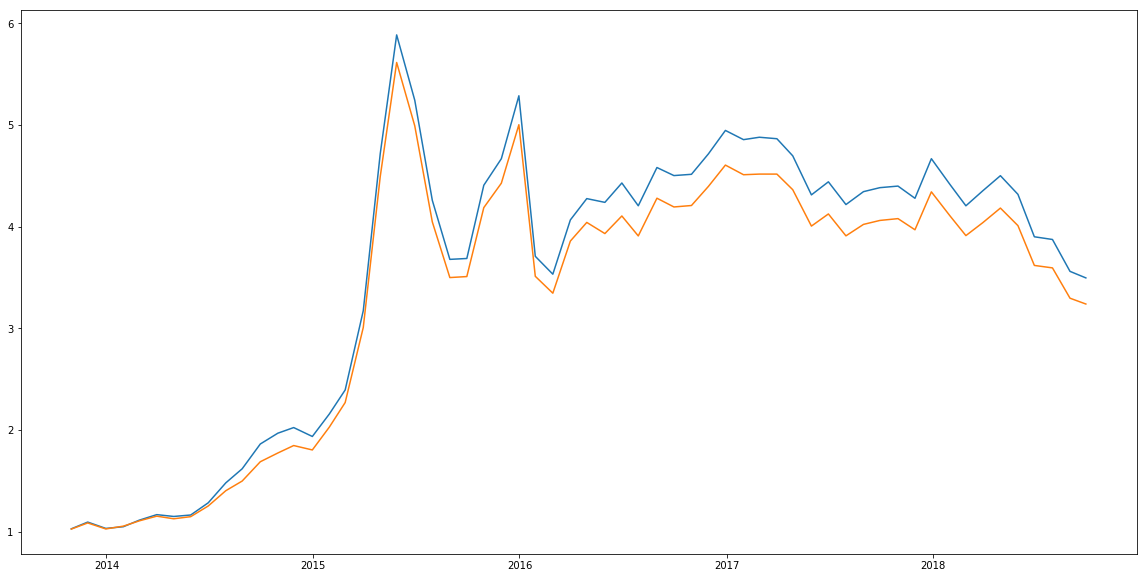

In [28]:
plot_multiple_series(final_return_df,"date", ["cum_ret_1","cum_ret_2"])

In [29]:
stock_index = pd.read_csv('Data/Chinese_stock_index.csv')
obj = BasicManipulation()
stock_index = obj.multiple_asset_return_calculation(stock_index,by='ticker',target='price',index_name='date',
                                      ticker_list = ['399001.SZ','000300.SS','000001.SS'],
                                     frequency = 'BM',log_ret =False)

In [31]:
sz_index = stock_index[stock_index['ticker']=='399001.SZ']
sz_index['date']= pd.to_datetime(sz_index['date'])
sz_index = sz_index[sz_index['date']>='2013-10-31']
obj_cum = ModelFreeEvaluation(sz_index['price'],ret_date = sz_index['date'])
sz_index['sz_cum_ret'] = obj_cum.cum_ret_calculation()

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [32]:
ss_index = stock_index[stock_index['ticker']=='000001.SS']
ss_index['date']= pd.to_datetime(ss_index['date'])
ss_index = ss_index[ss_index['date']>='2013-10-31']
obj_cum = ModelFreeEvaluation(ss_index['price'],ret_date = ss_index['date'])
ss_index['ss_cum_ret'] = obj_cum.cum_ret_calculation()

In [35]:
sz300 = stock_index[stock_index['ticker']=='000300.SS']
sz300['date']= pd.to_datetime(sz300['date'])
sz300 = sz300[sz300['date']>='2013-10-31']
obj_cum = ModelFreeEvaluation(sz300['price'],ret_date = sz300['date'])
sz300['sz300_cum_ret'] = obj_cum.cum_ret_calculation()

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [37]:
final_return_df = final_return_df.merge(sz_index,how='left',on='date')
final_return_df = final_return_df.merge(ss_index,how='left',on='date')
final_return_df = final_return_df.merge(sz300,how='left',on='date')

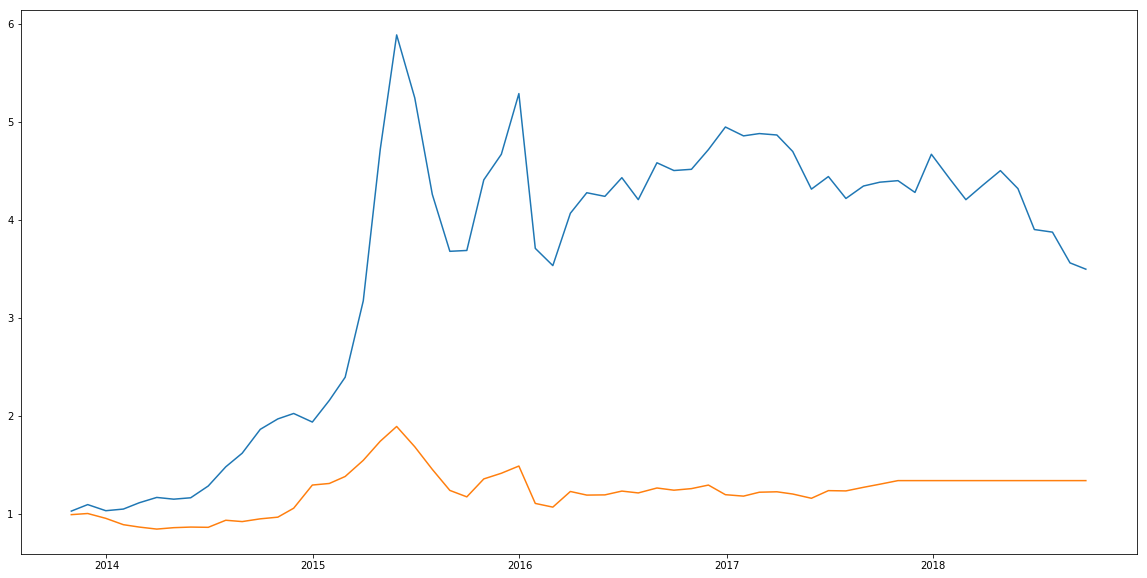

In [39]:
plot_multiple_series(final_return_df,"date", ["cum_ret_1","sz_cum_ret"])

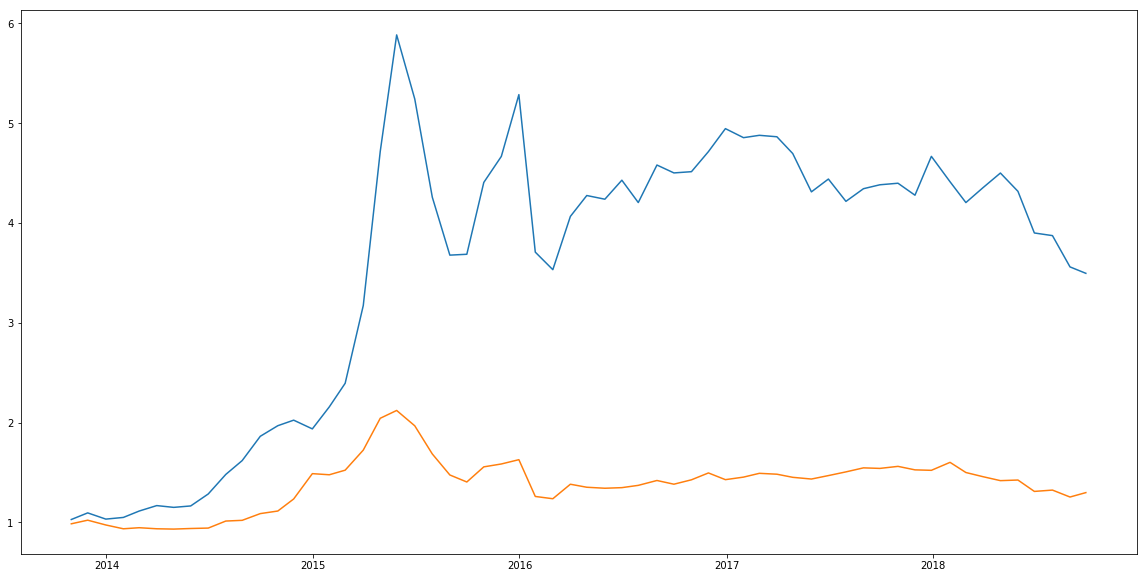

In [42]:
plot_multiple_series(final_return_df,"date", ["cum_ret_1","ss_cum_ret"])

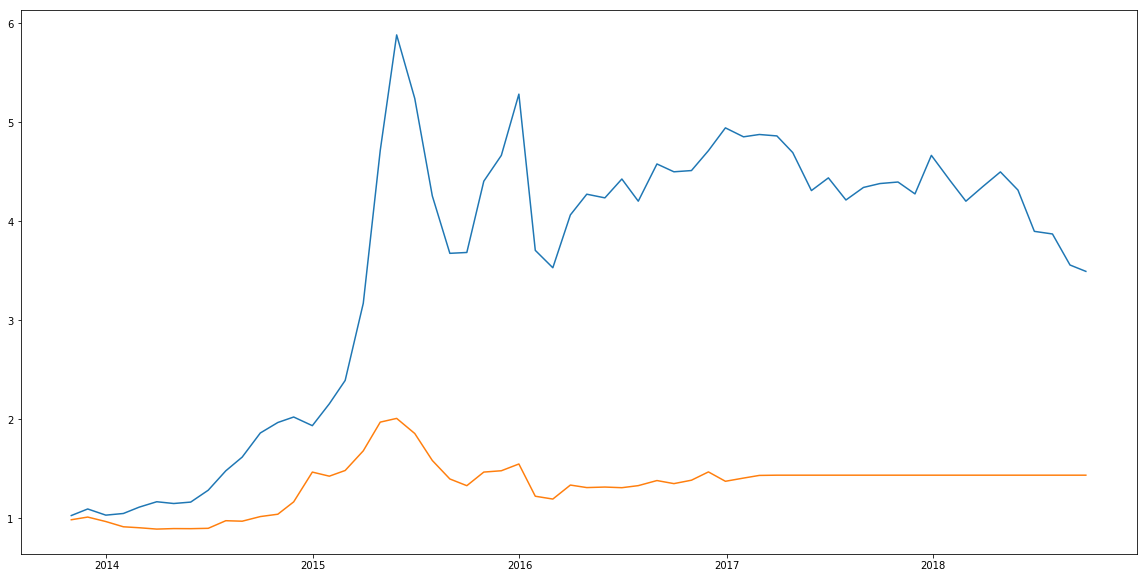

In [43]:
plot_multiple_series(final_return_df,"date", ["cum_ret_1","sz300_cum_ret"])